# Project recommendations for repeat donors

Here, we are interested in analyzing a dataset posted by DonorsChoose.org, an organization that matches requests (projects) from public school teachers with individual donors.  The goal is to use natural language features from the project descriptions in order to recommend specific classroom requests to prior donors.  In contrast to many of the datasets hosted on kaggle, there is no withheld test data or evaluation metric, so justifying the effectiveness of analysis is part of the project.  This problem is also a nice example of using "data science for good" to improve a non-profit in the education space. See https://www.kaggle.com/donorschoose/io for the data files.

The first step for our analysis is to load the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as math

# 1.1m rows
projects_ff = pd.read_csv('Projects.csv')
# 4.6m rows
donations_ff = pd.read_csv('Donations.csv')
# Some donations were missing valid project IDs...
df = donations_ff.merge(projects_ff, on="Project ID", how="inner")
df.head(3)

,Project ID,Donation ID,Donor ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,Donation Received Date,School ID,Teacher ID,Teacher Project Posted Sequence,...,Project Need Statement,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date
0,000009891526c0ade7180f8423792063,688729120858666221208529ee3fc18e,1f4b5b6e68445c6c4a0509b3aca93f38,No,178.37,11,2016-08-23 13:15:57,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,...,My students need a cart to help us manage our ...,Music & The Arts,Music,Grades 6-8,Other,529.68,2016-05-13,2016-09-12,Fully Funded,2016-08-23
1,000009891526c0ade7180f8423792063,dcf1071da3aa3561f91ac689d1f73dee,4aaab6d244bf3599682239ed5591af8a,Yes,25.00,2,2016-06-06 20:05:23,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,...,My students need a cart to help us manage our ...,Music & The Arts,Music,Grades 6-8,Other,529.68,2016-05-13,2016-09-12,Fully Funded,2016-08-23
2,000009891526c0ade7180f8423792063,18a234b9d1e538c431761d521ea7799d,0b0765dc9c759adc48a07688ba25e94e,Yes,20.00,3,2016-06-06 14:08:46,5aa86a53f658c198fd4e42c541411c76,6d5b22d39e68c656071a842732c63a0c,6,...,My students need a cart to help us manage our ...,Music & The Arts,Music,Grades 6-8,Other,529.68,2016-05-13,2016-09-12,Fully Funded,2016-08-23


In order to cut down on memory/time, we take a smaller random sample for testing and development.

In [2]:
# REDUCED SIZE FOR TESTING/DEVELOPMENT
donations = df.sample(n=100000)[['Project ID', 'Donation ID', 'Donor ID', 'Donation Amount', 'Donation Received Date']]

projects = projects_ff.loc[ projects_ff["Project ID"].isin(donations["Project ID"]) ].copy()
projects = projects.reset_index(drop = True)

print(" loaded", len(donations), "donations and", len(projects), "projects.")

 loaded 100000 donations and 88233 projects.


The donation amounts vary widely and are dominated by small-dollar donations, so we use a log transform to smooth them out.

Before smoothing:


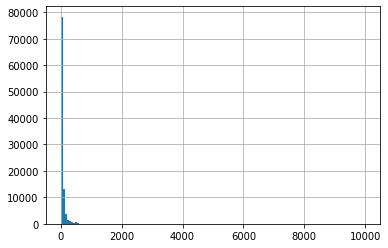

After smoothing:


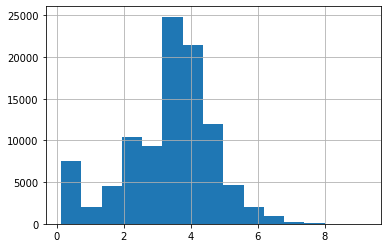

In [3]:
print("Before smoothing:")
donations["Donation Amount"].hist(bins=150)
plt.show()

# smooth out the donation amounts...
donations["Donation Amount"] = donations["Donation Amount"].apply(lambda x : math.log(1+x))

print("After smoothing:")
donations["Donation Amount"].hist(bins=15)
plt.show()


The basic structure of the data is that each **donor** typically interacts with several **projects**.  Each interaction is a **donation**.  We split the set of donations into training and test sets.  Our hope is to build a model using the **training set** that can accurately predict donations (for a particular donor) from the **test set**.

In [44]:
##
## Split the donations
##
from sklearn.model_selection import train_test_split 

donations_train, donations_test = train_test_split(donations, test_size=0.5)
print(len(donations_train), len(donations_test))

50000 50000


Next we build a list of donors ranked by the number of projects to which they have each contributed.  We broke down the number of projects they contributed to in terms of training (which we view as past projects) and test (which we view as future projects that we would like to predict).

In [45]:
##
## Find the top donors (by number of projects)
##

MIN_FREQ = 3

top_donors = pd.DataFrame(donations_train['Donor ID'].value_counts())
top_donors.columns = ['freq']
top_donors['Donor ID'] = top_donors.index
top_donors = top_donors.loc[top_donors.freq >= MIN_FREQ]

td_test = pd.DataFrame(donations_test.merge( top_donors, on="Donor ID", how="inner" ).groupby("Donor ID")["Project ID"].count())
td_test.columns = ['test_freq']
td_test = td_test.loc[td_test.test_freq >= MIN_FREQ]

top_donors = top_donors.merge(td_test, on="Donor ID", how="inner")
top_donors[:30]

,freq,Donor ID,test_freq
0,198,39df9399f5384334a42905bcf0acdcbf,202
1,148,237db43817f34988f9d543ca518be4ee,161
2,112,a0e1d358aa17745ff3d3f4e4909356f3,115
3,88,6f74ffb17cbb2b616b1eef06bd4acd0c,120
4,77,19f24640d9da49f6f8b4c9938c049591,62
5,70,6a35a7514005c04f8520e5d8f7657d91,46
6,63,0e345dcdef0d2a36c9bd17bf1ac3e10a,46
7,62,a1929a1172ad0b3d14bc84f54018c563,80
8,60,74f7db06bcd9557d1e992dc029db69cc,67
9,55,b51c76411b51751f45527c63c69ead9e,64


We use the training data to create a **Project x Feature matrix** that is inferred (using the TF-IDF model) from the text of the Project Essay associated to each project.

In [33]:
#
# Model training
#

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# Preprocessing of text data
textfeats = ["Project Essay"]
for cols in textfeats:
    projects[cols] = projects[cols].astype(str) 
    projects[cols] = projects[cols].astype(str).fillna('') # FILL NA
    projects[cols] = projects[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently 
text = pd.Series(projects["Project Essay"])

basic_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', stop_words='english')
tuned_vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', stop_words='english', 
                                   ngram_range = (1,3), max_features=2500 )
vectorizer = tuned_vectorizer

PF_MATRIX = vectorizer.fit_transform(text)
tfidf_feature_names = vectorizer.get_feature_names()

project_row_to_id = dict(projects['Project ID'])
project_id_to_row = {value: key for key, value in project_row_to_id.items()}

PF_MATRIX


<88233x2500 sparse matrix of type '<class 'numpy.float64'>'
	with 8947410 stored elements in Compressed Sparse Row format>

Next we build the methods for recommendation.

For each donor, we look up the projects they have contributed to in the past, and create a weighted average (using the smoothed donation amount as the weight) of the feature vectors for those projects.

To make recommendations, we then rank the projects in the **Project x Feature matrix** using cosine similarity with the donor vector we created.


In [46]:
#
# Model definition
#

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

def get_project_profile_vector(proj_id):
    return PF_MATRIX[project_id_to_row[proj_id]]

def get_donor_profile_vector(donor_id):
    donor_projects = donations_train.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    weighted_average = 0
    total_weight = donor_projects["Donation Amount"].sum()
    for i in range(len(donor_projects)):
        projid, projam = donor_projects.iloc[i][["Project ID", "Donation Amount"]]
        pf_vector = PF_MATRIX[project_id_to_row[projid]]
        rel_weight = projam / total_weight
        weighted_average = weighted_average + pf_vector*rel_weight
    weighted_average = normalize(weighted_average.reshape(1, -1))  ## N.B. new
    return weighted_average

def get_future_donation_rows(donor_id):
    donor_projects_test = donations_test.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    return list(donor_projects_test["Project ID"].map(project_id_to_row))

def get_past_donation_rows(donor_id):
    donor_projects_train = donations_train.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    return list(donor_projects_train["Project ID"].map(project_id_to_row))

def get_random_donation_rows(n):
    return list(projects.sample(n).index)

def recommend_for( donor_id ):
    weighted_average = get_donor_profile_vector(donor_id)
    scores = pd.DataFrame(cosine_similarity(PF_MATRIX, weighted_average.reshape(1, -1), dense_output = True))
    scores.columns = ['score']
    scores.sort_values(by='score', ascending=False, inplace=True)
    scores['Project ID'] = scores.index.map(project_row_to_id)

    donor_projects = donations_train.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    scores['has donated'] = scores['Project ID'].isin(donor_projects['Project ID'])
    
    donor_projects_test = donations_test.loc[donations["Donor ID"]==donor_id][['Project ID', 'Donation Amount']]
    scores['will donate'] = scores['Project ID'].isin(donor_projects_test['Project ID'])

    return scores

def recommend_filtered( scores, top_n = 50, filter_projects = None ):
    if filter_projects != None:
        scores = scores.loc[scores.index.isin(filter_projects)] 

    return scores.head(top_n)

#recommend_for(test_donor_id, 20)

In order to evaluate the model, we create an experiment for each donor and project from the test set (for that donor).  The experiment places the project that the donor actually contributed to among 99 other randomly selected projects and asks the recommendation system to rank the 100 projects.  We deem the experiment successful if the relevant project appears in the top 10 recommendations.  This is a measure of **recall** for our recommendation system.

In [14]:
# We ran two sets of tests, one used basic_vectorizer to create PF_MATRIX while the other used tuned_vectorizer...
TESTS_BASIC = []
TESTS_TUNED = []

In [47]:
#
# Model testing
#

def recall_at(donor_id, N = 10):
    ranks = []
    the_recs = recommend_for( donor_id )
    for proj in get_future_donation_rows(donor_id):
        one_out_of_99_exp = [ proj ]
        one_out_of_99_exp.extend( get_random_donation_rows(99) )
        recs = recommend_filtered(the_recs, N, one_out_of_99_exp)
        recs = recs.reset_index()
        try:
            rank = recs.loc[recs['index'] == proj].index[0]+1
            ranks.append(rank)
        except:
            ranks.append(-1)
    return len([ r for r in ranks if r > 0 and r <= 10 ]) / len(ranks)

recalls = []
#for row in top_donors["Donor ID"]:
for row in top_donors[:20]["Donor ID"]:
    rar = recall_at(row)
    print( rar, "= recall@10 for top donor", row )
    recalls.append( rar )
print("Average recall@10 for top donors: ", sum(recalls)/len(recalls) )


0.8267326732673267 = recall@10 for top donor 39df9399f5384334a42905bcf0acdcbf
0.4782608695652174 = recall@10 for top donor 237db43817f34988f9d543ca518be4ee
0.1826086956521739 = recall@10 for top donor a0e1d358aa17745ff3d3f4e4909356f3
0.10833333333333334 = recall@10 for top donor 6f74ffb17cbb2b616b1eef06bd4acd0c
0.3870967741935484 = recall@10 for top donor 19f24640d9da49f6f8b4c9938c049591
0.21739130434782608 = recall@10 for top donor 6a35a7514005c04f8520e5d8f7657d91
0.34782608695652173 = recall@10 for top donor 0e345dcdef0d2a36c9bd17bf1ac3e10a
0.1125 = recall@10 for top donor a1929a1172ad0b3d14bc84f54018c563
0.19402985074626866 = recall@10 for top donor 74f7db06bcd9557d1e992dc029db69cc
0.078125 = recall@10 for top donor b51c76411b51751f45527c63c69ead9e
0.15555555555555556 = recall@10 for top donor a299db9679f7746a805fbc300362191d
0.12244897959183673 = recall@10 for top donor 86d57a6264726b2a94c5b9663f46330c
0.23214285714285715 = recall@10 for top donor f37b9ff133242d08658ca2b17b3ab84c
0

In [48]:
TESTS_TUNED.append( recalls.copy() )
#TESTS_BASIC.append( recalls.copy() )


We ran three trials (not shown) using each of the basic_vectorizer and tuned_vectorizer models to create PF_MATRIX.  The tuned_vectorizer adds bi- and tri- grams to its vocabulary but also limits the size of the vocabulary to record the most significant features.

Comparing these, we see that the tuned model outperformed the basic model by several percentage points.

tuned mean 0.22953121521812142  >= basic mean 0.189697024485991


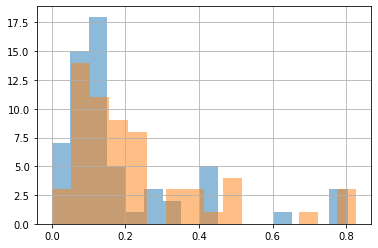

In [59]:
flatten = lambda l: [item for sublist in l for item in sublist]
tb = pd.Series(flatten(TESTS_BASIC)) # This series was created using the basic_vectorizer to create PF_MATRIX
tt = pd.Series(flatten(TESTS_TUNED)) # This series was created using the tuned_vectorizer to create PF_MATRIX
tb.hist(alpha = 0.5, bins=16)
tt.hist(alpha = 0.5, bins=16)

print( "tuned mean", tt.mean(), " >= basic mean", tb.mean() )

# Future work

These results should be viewed as a baseline for improvement.  There are several other features beyond the "Project Essay" text that we could use to build a hybrid model.  For example, we could consider the state where the school is located or the grade level of the classroom.  There are also other hyper-parameters to tune for the TF-IDF model.

It would also be interesting to replace the TF-IDF model with Word2Vec or Doc2Vec.
